### Overview:
In this notebook, the **Hierarchical Nearest Neighbor Interpolation** (*HNNI*) routine from [Maltsev et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..86M/abstract) is presented. It is a method for automated interpolation of stellar evolution tracks that does not require their segmetation into separate evolutionary phases. The *HNNI* method is a more accurate but computationally more expensive alternative to automated interpolation with supervised machine learning (ML). It has been demonstrated to work on the MIST stellar evolution catalog pre-computed by [Choi et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...823..102C/abstract), but the method itself is general. Here, we will first see how to use it to predict stellar evolution tracks from the zero-age-main-sequence (ZAMS) up to the end of core-helium-burning (CHeB) for any ZAMS mass $M_\mathrm{ZAMS}/M_\odot \in (0.7, 300)$ at fixed metallicity. Then, we will look into how it generalizes to higher-dimensional parameter spaces (for example, stellar track interpolation over $M_\mathrm{ZAMS}$ and over the ZAMS metallicity $Z$).

### Table of Content:
Here is an overview of what will be covered in this Notebook:
1. Loading the catalog data
2. The timescale-adapted evolutionary coordinate
3. The *HNNI* method 
4. Generalization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## 1. Loading the catalog data
First, let's load the stellar evolution catalog data base, which *HNNI* requires the access to. Here, we use the MIST catalog at solar metallicity [Fe / H] = 0. The data is loaded using the *MIST_data_reader()* method, which is defined in the script *processing_and_plotting_routines.py* that is imported into this Notebook. The catalog data base is organized as a dictionary *catalog_data*, whose entries are ZAMS masses $M_\mathrm{ZAMS}$ in units of the solar mass $M_\odot$. For each $M_\mathrm{ZAMS}/M_\odot$-entry in the dictionary, *catalog_data* returns a data frame whose columns are stellar evolution variables, such as the bolometric luminosity $\log L$. The stellar variable namings and units are given in the [MIST readme file](https://waps.cfa.harvard.edu/MIST/README_tables.pdf). If you want to choose a different set of MIST variables than in the example here, you need to modify the *basic_columns*-list in the *HNNI_routines.py* script that is imported into this Notebook.

In [2]:
from processing_and_plot_routines import *
from HNNI_routines import *

In [3]:
MIST_df = MIST_data_reader(initial_masses, dict1, data_path, phases_list, basic_columns) # original MIST catalog data at solar metallicity
WebInt_df = MIST_data_reader(webint_masses, dict2, webint_path, phases_list, basic_columns) # additional data generated using the MIST Web Interpolator
catalog_data = merge_two_dicts(MIST_df, WebInt_df)

Reading in: ../data/Fe-H0.0vvcrit0.0/00070M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00075M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00080M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00085M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00090M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00092M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00094M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00096M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00098M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00100M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00102M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00104M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00106M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00108M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00110M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00112M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00114M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/00116M.track.eep
Reading in: ../data/Fe-H0.0v

Reading in: ../data/Fe-H0.0vvcrit0.0/06500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/07000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/07500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/08000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/08500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/09000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/09500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/10000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/10500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/11000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/11500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/12000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/12500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/13000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/13500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/14000M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/14500M.track.eep
Reading in: ../data/Fe-H0.0vvcrit0.0/15000M.track.eep
Reading in: ../data/Fe-H0.0v

In [4]:
# ZAMS masses in the catalog
np.ravel(sorted(catalog_data.keys()))

array([  0.675,   0.7  ,   0.725,   0.75 ,   0.775,   0.8  ,   0.825,
         0.85 ,   0.875,   0.9  ,   0.92 ,   0.94 ,   0.96 ,   0.98 ,
         1.   ,   1.02 ,   1.04 ,   1.06 ,   1.08 ,   1.1  ,   1.12 ,
         1.14 ,   1.16 ,   1.17 ,   1.18 ,   1.19 ,   1.2  ,   1.21 ,
         1.22 ,   1.23 ,   1.24 ,   1.25 ,   1.26 ,   1.27 ,   1.28 ,
         1.29 ,   1.3  ,   1.31 ,   1.32 ,   1.33 ,   1.34 ,   1.35 ,
         1.36 ,   1.37 ,   1.38 ,   1.39 ,   1.4  ,   1.41 ,   1.42 ,
         1.43 ,   1.44 ,   1.45 ,   1.46 ,   1.47 ,   1.48 ,   1.49 ,
         1.5  ,   1.52 ,   1.54 ,   1.56 ,   1.58 ,   1.6  ,   1.62 ,
         1.64 ,   1.66 ,   1.68 ,   1.7  ,   1.72 ,   1.74 ,   1.76 ,
         1.78 ,   1.8  ,   1.82 ,   1.84 ,   1.86 ,   1.88 ,   1.9  ,
         1.92 ,   1.94 ,   1.96 ,   1.98 ,   2.   ,   2.02 ,   2.04 ,
         2.06 ,   2.08 ,   2.1  ,   2.12 ,   2.14 ,   2.16 ,   2.18 ,
         2.2  ,   2.22 ,   2.24 ,   2.26 ,   2.28 ,   2.3  ,   2.32 ,
         2.34 ,   2.

In [5]:
# stellar variables for a star with a ZAMS mass of one solar mass
catalog_data[1.0]

,log_L,log_Teff,star_age,phase,log_center_Rho,center_he4,log_center_T,log_g,s_tilde,s
0,-0.127209,3.756412,4.187347e+07,0.0,1.897455,0.270918,7.135825,4.545648,0.000000,0.000000
1,-0.127488,3.756263,4.320108e+07,0.0,1.897093,0.270976,7.135414,4.545329,0.000481,0.000040
2,-0.127470,3.756155,4.456601e+07,0.0,1.896819,0.271036,7.135046,4.544880,0.000776,0.000065
3,-0.127236,3.756077,4.595801e+07,0.0,1.896608,0.271098,7.134708,4.544335,0.001100,0.000092
4,-0.126810,3.756042,4.742354e+07,0.0,1.896540,0.271163,7.134444,4.543767,0.001533,0.000128
...,...,...,...,...,...,...,...,...,...,...
500,1.957497,3.640639,1.144747e+10,3.0,4.653971,0.000732,8.264065,1.976055,11.890477,0.993644
501,1.967888,3.639664,1.144750e+10,3.0,4.669333,0.000547,8.266779,1.961761,11.909049,0.995196
502,1.978203,3.638662,1.144752e+10,3.0,4.685030,0.000396,8.269276,1.947439,11.927858,0.996768
503,1.988483,3.637668,1.144754e+10,3.0,4.701141,0.000274,8.271515,1.933182,11.946996,0.998367


## 2. The timescale-adapted evolutionary coordinate
The primary interpolation variable of the *HNNI* method is the timescale-adapted evolutionary coordinate $s$ introduced in Sect. 2.1, [Maltsev et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..86M/abstract). Parametrizing stellar evolution as a function of $s$ across evolutionary phases has the advantage that variability (happening on orders of magnitude separated timescales) is casted onto a unified numerical scale along $s$.

The $s$-coordinate is computed for each star from the timeseries (from the **same** evolutionary start- and up to the **same** endpoint, which here are the ZAMS and the end of CHeB, respectively,) of its $\log L$, $\log T_\mathrm{eff}$ and $\log \rho_c$ variables, where $\rho_c$ is the core density and $T_\mathrm{eff}$ the effective temperature. In what follows, we will see how this works.

Stellar age $\tau_i = \sum_{j=1}^i \delta t_j$  after computation step $i$ is a monotonically increasing function which grows cumulatively at an adaptive step size $\delta t_j$ after each step $j=1, \dots, i$ of numerical time integration of the differential equations describing stellar structure and evolution. The age proxy variable $s_i = \sum_{j=1}^i \delta s_j$ is constructed analogously, but here $\delta s_j$ is the increment in the star's Euclidean displacement in a diagram spanned by a set of its physical variables, obtained after the numerical time integration step $j=1, \dots, i$. It is calculated using the following prescription,
 
 \begin{align}
    \delta \tilde{s}_j = \sqrt{ \left| \Delta_\mathrm{j,j-1}\log \frac{L}{\mathrm{L_\odot}} \right|^2+ \left| \Delta_\mathrm{j,j-1} \log \frac{T_\mathrm{eff}}{\mathrm{K}} \right|^2+ \left| \Delta_\mathrm{j,j-1} \log \frac{\rho_{c}}{[\mathrm{g} \cdot \mathrm{cm}^{-3}]} \right|^2 },
 \end{align}

where $\Delta_\mathrm{j,j-1} X = X_j - X_\mathrm{j-1}$. After normalization $\tilde{s} \rightarrow s$, the unified range is $s \in (0,1)$ for each star. When $s=0$, the star is at the ZAMS and when $s=1$, at the end of CHeB.

In the *catalog_data* we are looking at here, we have already pre-computed the $s$-coordinate for each star of different $M_\mathrm{ZAMS}$. If you use your own stellar evolution catalog, you will need to compute it for each stellar track and then add it as an additional column to the data frame for each star. You can use the *s_calculation*() routine defined below, which returns the (normalized) $s$-"timeseries" when given the input of the $\log \frac{L}{\mathrm{L_\odot}}$, $\log \frac{T_\mathrm{eff}}{\mathrm{K}}$ and $\log \frac{\rho_{c}}{[\mathrm{g} \cdot \mathrm{cm}^{-3}]}$ timeseries:

In [6]:
# method to calculate the timescale-adapted evolutionary coordinate s
def s_calculation(logL, logTeff, logRho):
    delta_c = 0
    path_length_list = [delta_c]    
    for i in range(0, len(logL)-1):
        lumi, lumj = logL[i], logL[i+1]
        tempi, tempj = logTeff[i], logTeff[i+1]
        nuci, nucj = logRho[i], logRho[i+1]
        delta_l = abs(lumj-lumi)
        delta_T = abs(tempj-tempi)
        delta_nuc = abs(nuci-nucj)
        delta_c = delta_c + np.sqrt(delta_l**2+delta_T**2+delta_nuc**2)
        path_length_list.append(delta_c)  
    return path_length_list/path_length_list[-1]

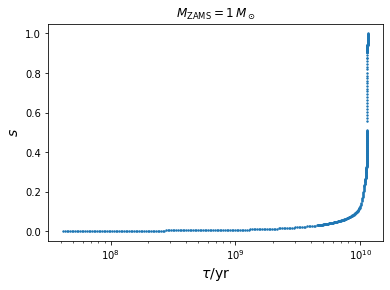

In [7]:
# example: s calculation for the 1 solar mass star
s_1msun = s_calculation(catalog_data[1.0]['log_L'], catalog_data[1.0]['log_Teff'], catalog_data[1.0]['log_center_Rho'])

# plotting s vs stellar age
plt.figure()
plt.scatter(catalog_data[1.0]['star_age'], s_1msun, s = 2)
plt.xscale('log')
plt.xlabel(r'$ \tau / \mathrm{yr}$', fontsize = 14)
plt.ylabel('$ s$', fontsize = 14)
plt.title(r'$M_\mathrm{ZAMS} = 1 \, M_\odot$')
plt.show()

For comparison, take a look at the bolometric luminosity evolution of a Sun-like star from the ZAMS up to the end of CHeB parametrized as function of stellar age $\tau$ (left panel) versus of the timescale-
adapted evolutionary coordinate $s$. With the latter, the first dredge-up on the MS and the variability during the post-MS evolution (red giant branch, helium flashes, horizontal branch, ...) are much better resolved.

Text(0, 0.5, '$ \\log L/L_\\odot$')

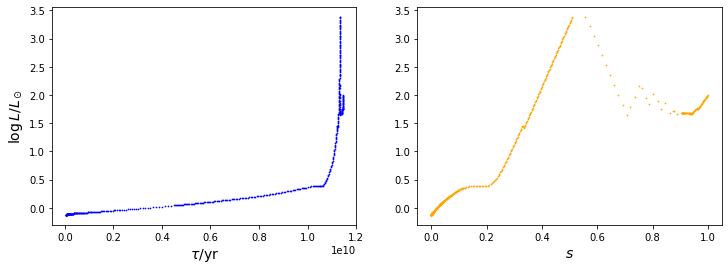

In [8]:
ssize = 0.5

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].scatter(catalog_data[1.0]['star_age'], catalog_data[1.0]['log_L'], color = 'blue', s = ssize)
ax[1].scatter(s_1msun, catalog_data[1.0]['log_L'], color = 'orange', s = ssize)

ax[0].set_xlabel(r'$ \tau / \mathrm{yr}$', fontsize = 14)
ax[1].set_xlabel(r'$ s$', fontsize = 14)
ax[0].set_ylabel(r'$ \log L/L_\odot$', fontsize = 14)

## 3. The HNNI method:
The key principle is to select the nearest available grid points, from above and from below, in each parameter space direction, to the location in parameter space at which the interpolation prediction is to be made, and then apply a 1D interpolation prescription subsequently in each parameter space direction according to a hierarchical order of parameters. 

The method works similar to [Brott et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...530A.116B/abstract) in that it performs a sequence of linear interpolations separately in each parameter space direction according to a hierarchical ordering of stellar variables, but different from it in that it uses a timescale-adapted evolutionary coordinate, instead of fractional age, as primary interpolation variable. The method is therefore applicable not only to the MS evolution but to a sequence of evolutionary phases. In this regard, the *HNNI* method is analogous to [Agrawal et al. 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.4549A/abstract) in that it uses an adapted evolutionary coordinate to trace the evolution of stars across phases, but *HNNI* has the handy feature that a prescription for $s$ is used that allows to automate interpolation without the need to map out evolutionary points of interest that segment evolution into phases. For more *HNNI* details, see Sect. 3.4 and the Appendix B  in [Maltsev et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...681A..86M/abstract) where *HNNI* is introduced.

All routines needed for *HNNI* are defined in the *HNNI_routines.py* script that is imported here. The main function is *HNNI_general()*. As input, it expects the stellar evolution catalog (here: *catalog_data*), the choice of the variable $Y$ that is to be predicted (here: *target*), the ZAMS mass $M_\mathrm{ZAMS}$ (here: *zams_mass*) and the $s$-coordinate value (here: *s_val*) at which the interpolation prediction is to be made:

\begin{align}
Y_j = \mathrm{HNNI}(\mathrm{catalog}, M_\mathrm{ZAMS}, s_j, Y)
\end{align}

Here is an example where the central helium mass fraction is predicted for a $M_\mathrm{ZAMS} = 27 \, M_\odot$ star at $s_j = 0.1$:

In [9]:
HNNI_general(catalog_data, 27, 0.1, 'center_he4')

0.8215097543653963

To make this prediction, *HNNI_general* browses the catalog to first find the evolutionary tracks at the closest $M_\mathrm{ZAMS}$ values to $27 \, M_\odot$ (these are $M_\mathrm{ZAMS}^+ = 28 \, M_\odot$ and $M_\mathrm{ZAMS}^- = 26 \, M_\odot$). In these tracks, it then looks up *center_he4* at the the closest $s$-values to $s = 0.1$ from above and from below, that is $s^+(M_\mathrm{ZAMS}^+)$ and $s^-(M_\mathrm{ZAMS}^+)$ for $M_\mathrm{ZAMS}^+$, and analogously for $M_\mathrm{ZAMS}^-$. The next step is to interpolate (by default: linear interpolation) *center_he4* along $s$ for the $M_\mathrm{ZAMS}^+$ and the $M_\mathrm{ZAMS}^-$ tracks, respectively, and finally interpolate over these *center_he4* values along $\log M_\mathrm{ZAMS}/M_\odot$.

Our demonstration goal here is to show how to predict stellar evolution tracks for $M_\mathrm{ZAMS}$-values in-between the grid points available in the catalog data base. To assess the predictive accuracy, we have prepared a hold-out set of MIST stellar evolution tracks that is loaded below, for the comparison with the *HNNI* predictions.

In [10]:
test_masses_df = MIST_data_reader(initial_massesEEP[:], dict3, test_path, phases_list, basic_columns)

Reading in: ../data/MIST_eep_testP/0009100M.track.eep
Reading in: ../data/MIST_eep_testP/0015100M.track.eep
Reading in: ../data/MIST_eep_testP/0024100M.track.eep
Reading in: ../data/MIST_eep_testP/0041000M.track.eep
Reading in: ../data/MIST_eep_testP/0082500M.track.eep
Reading in: ../data/MIST_eep_testP/0162500M.track.eep
Reading in: ../data/MIST_eep_testP/0215000M.track.eep
Reading in: ../data/MIST_eep_testP/0315000M.track.eep
Reading in: ../data/MIST_eep_testP/0410000M.track.eep
Reading in: ../data/MIST_eep_testP/0510000M.track.eep
Reading in: ../data/MIST_eep_testP/0610000M.track.eep
Reading in: ../data/MIST_eep_testP/0837500M.track.eep
Reading in: ../data/MIST_eep_testP/1037500M.track.eep
Reading in: ../data/MIST_eep_testP/1550000M.track.eep
Reading in: ../data/MIST_eep_testP/2625000M.track.eep
Reading in: ../data/MIST_eep_testP/2950000M.track.eep


In [11]:
# define the set of variables you would like to have interpolated
targets = ["log_L", "log_Teff", "log_center_T", "log_center_Rho"]

# define range of ZAMS masses over which to get interpolated tracks
ZAMS_masses = initial_massesEEP

# for storing interpolation results at each of the ZAMS masses
HNNI_pred_dict = {}

for zams_mass in ZAMS_masses:
    
    # the s values at which the HNNI predictions will be made 
    s_values = test_masses_df[zams_mass]["s"] 
    
    # create dataframe for storing interpolation results
    HNNI_pred = pd.DataFrame(columns = targets)
    
    for target in targets:
        pred = []
        for s_val in s_values:
            pred_val = HNNI_general(catalog_data, zams_mass, s_val, target)
            pred.append(pred_val)
        
        HNNI_pred[target] = pred 
    HNNI_pred["s"] = test_masses_df[zams_mass]["s"] 
    HNNI_pred_dict[zams_mass] = HNNI_pred

In [12]:
# the interpolation results for all target variables are stored in the HNNI_pred_dict dictionary,
# HNNI_pred_dict returns a data frame with the interpolation results for each ZAMS mass entry.
zams_mass = initial_massesEEP[5]
print(zams_mass)
HNNI_pred_dict[zams_mass]

16.25


,log_L,log_Teff,log_center_T,log_center_Rho,s
0,4.384273,4.515402,7.558599,0.820866,0.000000
1,4.383557,4.515396,7.558738,0.821133,0.000197
2,4.382922,4.515347,7.558785,0.821136,0.000362
3,4.382359,4.515256,7.558745,0.820888,0.000522
4,4.381984,4.515153,7.558651,0.820513,0.000661
...,...,...,...,...,...
500,4.908556,3.538036,8.391326,3.328995,0.938088
501,4.916033,3.536740,8.410497,3.384949,0.952616
502,4.922559,3.535680,8.430053,3.443763,0.967843
503,4.927754,3.534861,8.450050,3.505140,0.983692


### prediction of a stellar variable evolution as a function of s: 
Let us now compare the HNNI predictions of the $\log L$ target variable to the actual $\log L$ data from the hold-out data set.

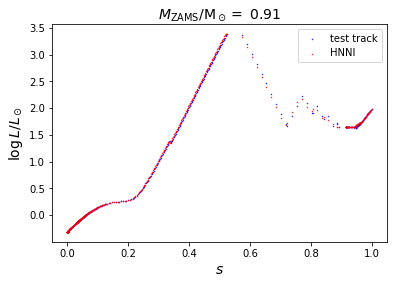

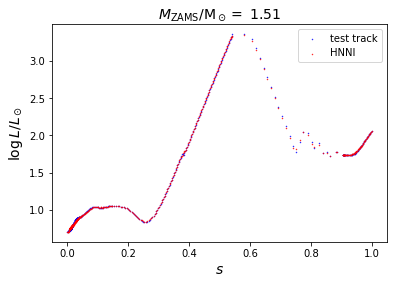

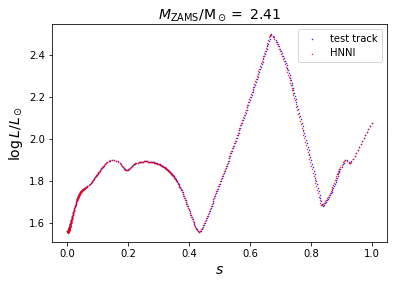

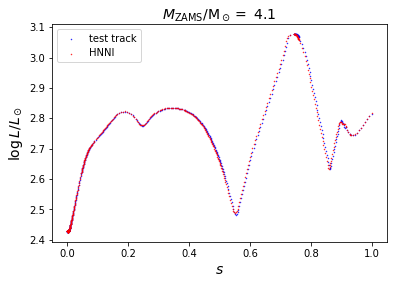

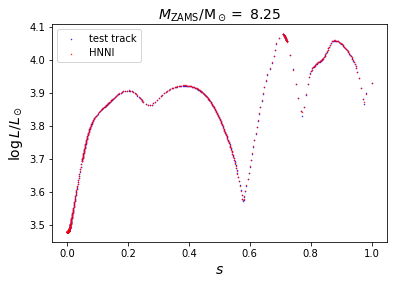

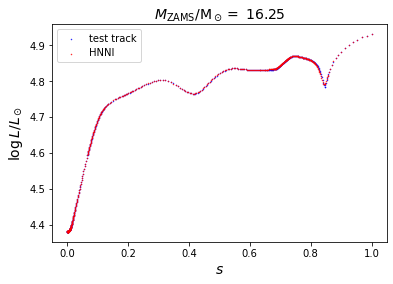

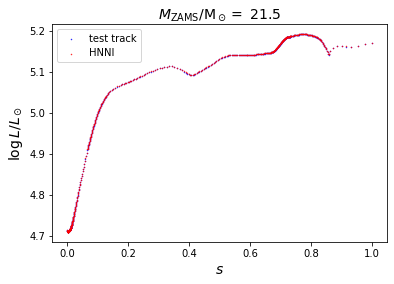

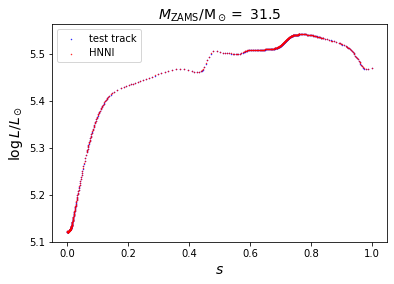

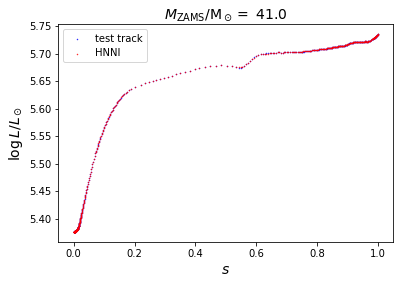

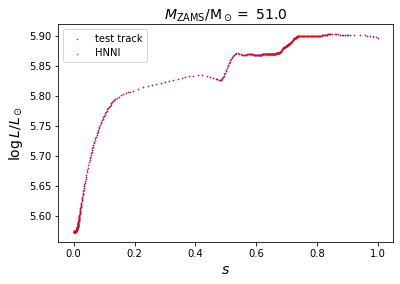

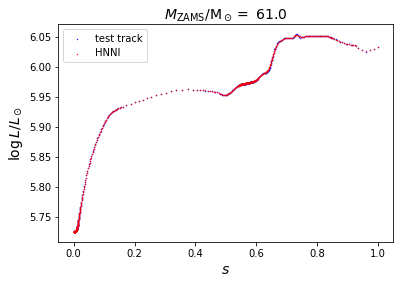

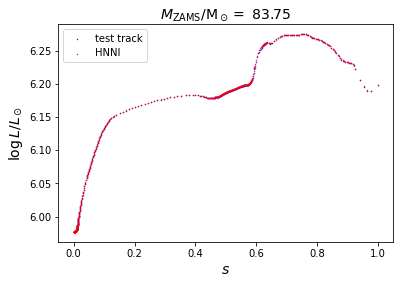

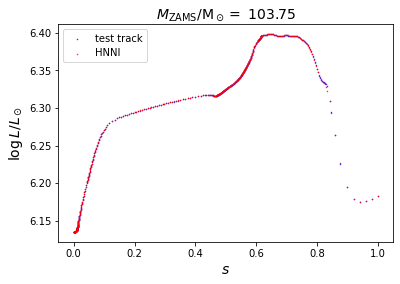

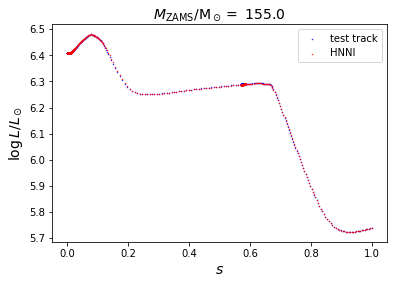

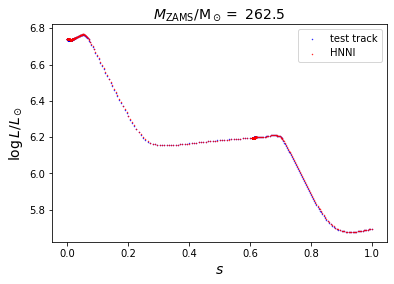

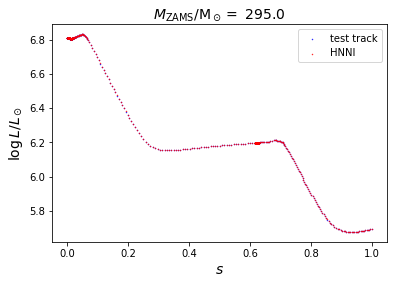

In [13]:
target = "log_L"
for mass in initial_massesEEP:
    plt.figure()

    plt.scatter(test_masses_df[mass]['s'], test_masses_df[mass][target], s = 0.2, color = 'blue', label = "test track")
    plt.scatter(HNNI_pred_dict[mass]['s'], HNNI_pred_dict[mass][target], s = 0.2, color = 'red', label = 'HNNI')

    plt.xlabel(r'$s$', fontsize = 14)
    plt.ylabel(r'$\log L / L_\odot$', fontsize = 14)
    plt.legend() 

    plt.title(r'$M_\mathrm{ZAMS}/ \mathrm{M_\odot}=$ '+str(mass), fontsize = 14)
    plt.show()

### prediction of evolutionary tracks in the Hertzsprung-Russell diagram:
We can also compare the interpolated tracks in the Hertzsprung-Russell diagram and the actual ($\log L$, $\log T_\mathrm{eff}$)-values as given in the hold-out data set:

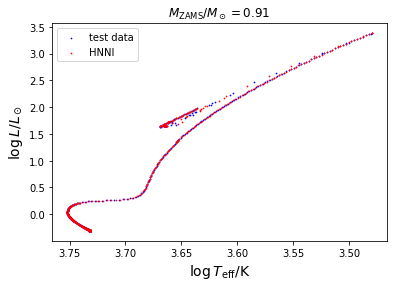

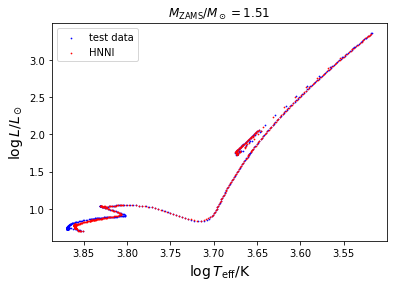

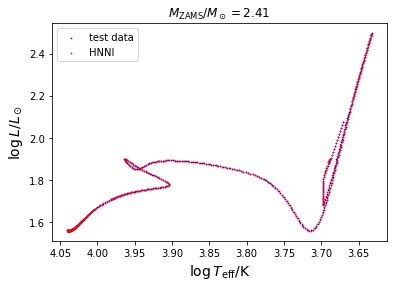

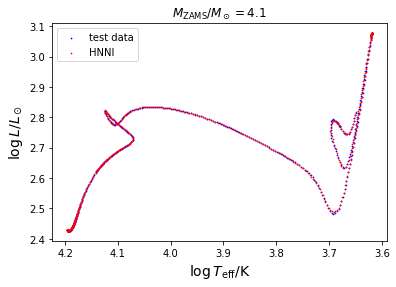

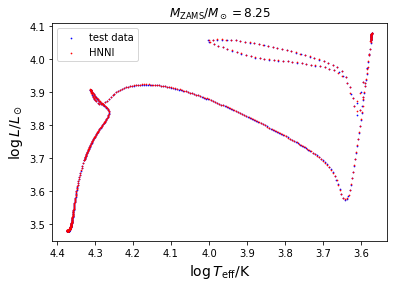

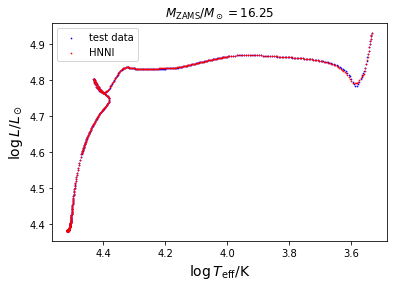

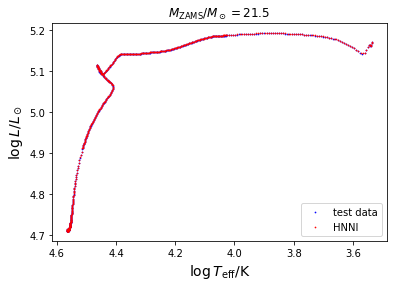

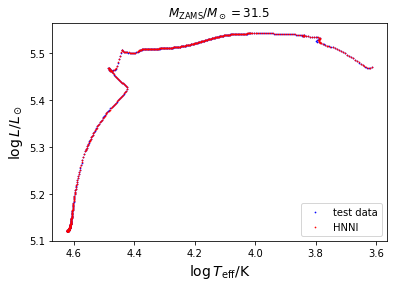

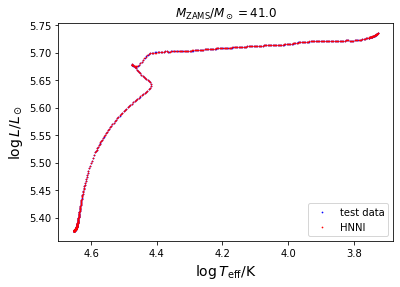

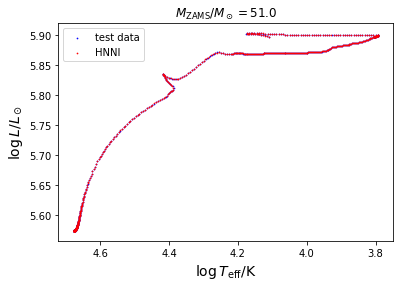

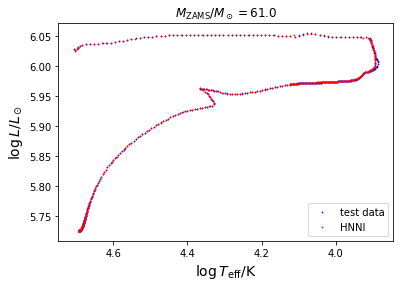

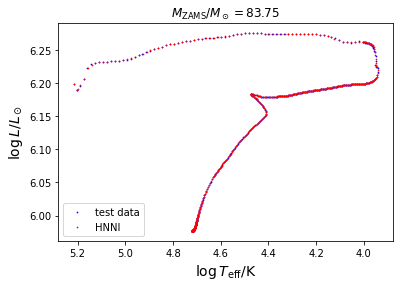

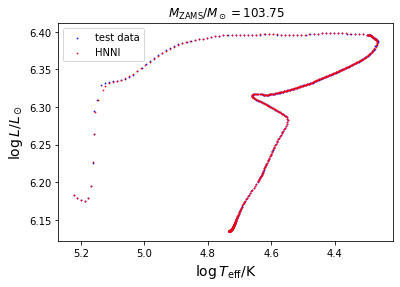

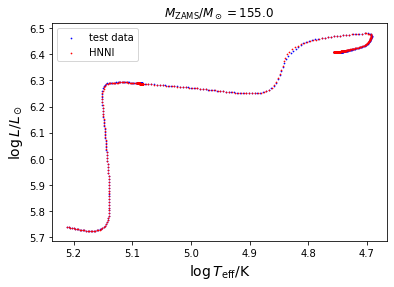

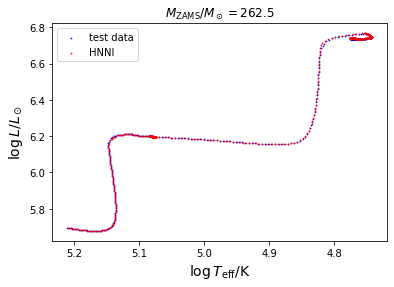

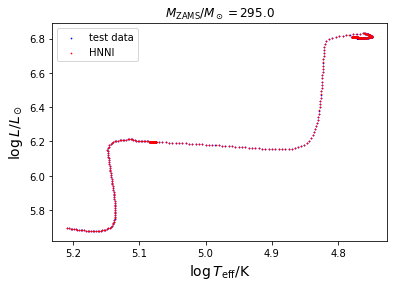

In [14]:
target_variables = ["log_Teff", "log_L"]

for m0 in initial_massesEEP:
    plt.close()
    plt.figure()
    x_pred = HNNI_pred_dict[m0][target_variables[0]]
    y_pred = HNNI_pred_dict[m0][target_variables[1]]
    x_test = test_masses_df[m0][target_variables[0]]
    y_test = test_masses_df[m0][target_variables[1]]
        
    plt.scatter(x_test, y_test, label = "test data", s = 0.5, color = "blue")
    plt.scatter(x_pred, y_pred, label = "HNNI", s = 0.5, color = "red")

    plt.gca().invert_xaxis()
    plt.ylabel(r'$\log L / L_\odot$', fontsize = 14)
    plt.xlabel(r'$\log T_\mathrm{eff} / \mathrm{K}$', fontsize = 14)
    plt.legend()
    plt.title("$M_\mathrm{ZAMS}/M_\odot =$"+str(m0))
    plt.show()

## 4. Generalization:
Let's assume that the stellar parameter space is spanned by a third dimension---the initial metallicity $Z$. The resulting set of parameters $(s, M_\mathrm{ZAMS}, Z)$ allows for a hierarchical ordering: Always first is the timescale-adapted evolutionary coordinate axis $s$. Always second is the ZAMS mass axis $M_\mathrm{ZAMS}$. Third and least significant out of the three, is the initial metallicity axis $Z$, whose effect on the shape of stellar evolutionary tracks - at fixed ZAMS mass - results in minor corrections.
The pseudo-code below provides the recipe for a numerical response to the following inquiry: What is the value of target variable $Y_j=Y(s_j)$ at the test location $(Z^\mathrm{test}, M_\mathrm{ZAMS}^\mathrm{test}, s_j)$ in the three-dimensional parameter space?


$Y$ is any evolved stellar variable: for example, $Y = \log L / \mathrm{L_\odot}$. For full generality, we assume that neither $M_\mathrm{ZAMS}^\mathrm{test}$ nor $Z^\mathrm{test}$ is contained in the catalog grid database spanned by $\{M_\mathrm{ZAMS}, Z\}_\mathrm{cat}$.

Below, the linear interpolation equation $y(x) = y_1 + \frac{y_2-y_1}{x_2 -x_1}(x-x_1)$ is referred to by its parameters: $y(x) \leftarrow y_2, y_1, x_2, x_1$. We assume that, in the catalog, a similar initial mass grid sampling density is available for each initial metallicity:

**Pseudo-code:**

1. Determine the nearest neighbors $Z^+, Z^- \in \{ Z \}_\mathrm{cat}$ to the test initial metallicity value $Z_\mathrm{ini}^\mathrm{test}$ from above and from below, respectively.
2. From the set of available initial masses $\{ M_\mathrm{ZAMS} \}(Z^+)$ and $\{ M_\mathrm{ZAMS} \}(Z^-)$ contained in the catalog at these two metallicities, determine the nearest neighbors to $M_\mathrm{ZAMS}^\mathrm{test}$ from above and from below, respectively:

    $M_{+}^+, M_{+}^- \in \{ M_\mathrm{ZAMS} \}(Z^+)$,
    
    $M_{-}^+, M_{-}^- \in \{ M_\mathrm{ZAMS} \}(Z^-)$.
3. From the age proxy series available in the catalog at each of these four initial mass grid points, find the nearest neighbors to $s_j$ along the age proxy axis that satisfy:

    $s_\mathrm{+,max}^+, s_\mathrm{+, min}^+ \in \{ s_i \}(M_{+}^+)$ with $s_\mathrm{+,min}^+<s_j<s_\mathrm{+,max}^+$,
    
    $s_\mathrm{+,max}^-, s_\mathrm{+, min}^- \in \{ s_i \}(M_{+}^-)$ with $s_\mathrm{+,min}^-<s_j<s_\mathrm{+,max}^-$,
    
    $s_\mathrm{-,max}^+, s_\mathrm{-, min}^+ \in \{ s_i \}(M_{-}^+)$ with $s_\mathrm{-,min}^+<s_j<s_\mathrm{-,max}^+$,
    
    $s_\mathrm{-,max}^-, s_\mathrm{-, min}^- \in \{ s_i \}(M_{-}^-)$ with $s_\mathrm{-,min}^-<s_j<s_\mathrm{-,max}^-$.
3. Interpolate along the age proxy axis to find

    $Y_+^+(s_j) \leftarrow Y_+^+(s_\mathrm{+,max}^+), Y_+^+(s_\mathrm{+,min}^+), s_\mathrm{+,max}^+, s_\mathrm{+,min}^+$,
    
    $Y_+^-(s_j) \leftarrow Y_+^-(s_\mathrm{+,max}^-), Y_+^-(s_\mathrm{+,min}^-), s_\mathrm{+,max}^-, s_\mathrm{+,min}^-$,
    
    $Y_-^+(s_j) \leftarrow Y_-^+(s_\mathrm{-,max}^+), Y_-^+(s_\mathrm{-,min}^+), s_\mathrm{-,max}^+, s_\mathrm{-,min}^+$,
    
    $Y_-^-(s_j) \leftarrow Y_-^-(s_\mathrm{-,max}^-), Y_-^-(s_\mathrm{-,min}^-), s_\mathrm{-,max}^-, s_\mathrm{-,min}^-$.
4. Interpolate along the log-scaled initial mass axis to find

    $Y_+(s_j) \leftarrow Y_+^+(s_j), Y_+^-(s_j), \log (M_{+}^+ / \mathrm{M_\odot}), \log (M_{+}^-/ \mathrm{M_\odot})$,
    
    $Y_-(s_j) \leftarrow Y_-^+(s_j), Y_-^-(s_j), \log (M_{-}^+ / \mathrm{M_\odot}), \log (M_{-}^- / \mathrm{M_\odot})$.
5. Interpolate along the log-scaled initial metallicity axis to find
    
     $Y(s_j) \leftarrow Y_+(s_j), Y_-(s_j), \log (Z^+/ \mathrm{Z_\odot}), \log (Z^- / \mathrm{Z_\odot})$.




### Higher-dimensional parameter spaces:

The *HNNI* method is extended analogously to higher-dimensional parameter spaces. The number $n$ of hierarchical 1D interpolations to perform and number $k$ of neighboring grid points to query scale as follows with dimensionality of the parameter space:
- 1D: $(s)$: $n = 1, k=2$ 
- 2D :$(s, M_\mathrm{ZAMS})$: $n = (1+1)+1=3, k = (2+2)+2=6$
- 3D: $(s, M_\mathrm{ZAMS}, Z)$: $n = (3+3)+1 = 7, k = (6 + 6) + 2=14$  
- 4D: $(s, M_\mathrm{ZAMS}, Z, v_\mathrm{ini})$: $n = (7+7)+1 = 15, k=(14 + 14)+2 = 30$.

Here, $v_\mathrm{ini}$ is the initial rotational velocity. We believe that the *HNNI* method is generalizable to even higher parameter space dimensions but have not verified this hypothesis. For a binary system composed of two non-rotating stars of the same initial metallicity, we expect the following hierarchical ordering of variables to yield accurate interpolation results:
- 5D: $(s_1, M_\mathrm{ini,1}, M_\mathrm{ini,2}, P_\mathrm{ini}, \epsilon_\mathrm{ini})$
with $n = (15+15)+1=31$, and $k = (30+30)+2=62$. 

Here, $P_\mathrm{ini}$ is the initial orbital period and $\epsilon_\mathrm{ini}$ the initial orbital eccentricity.

In [27]:
# Acknowledgement: Kiril Maltsev